# Problem 1 (50 points) Develop a multi-layer perceptron with three hidden layers (you pick the dimensions of the hidden layers) for the CIFAR-10 dataset.

1.a. Train the model from scratch (with randomized parameters) and plot the results (training loss and accuracy, validation accuracy) after 20 epochs. Does your network need more epochs for full training? Do you observe overfitting? Make sure to save the trained parameters and model. Report and plot your training and validation results. Report precision, recall, F1 score, and confusion matrix. (25pt)

1.b. Explore the complexity of the network by increasing its width and depth. How do the training and validation results change? Compare them against the baseline. Do you see any overfitting? (25pt)

Importing Libraries

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from torchsummary import summary

import numpy as np
import pandas as pd
import time

Dataset Pre-processing

In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-10 Dataset
CIFAR10_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Compute dataset mean and standard deviation for normalization
imgs = torch.stack([img_t for img_t, _ in CIFAR10_trainset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

# Define normalization transformation
normalize = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])

# Define Datasets
train_data = datasets.CIFAR10(root="./data", train=True, transform=normalize)
valid_data = datasets.CIFAR10(root="./data", train=False, transform=normalize)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

Files already downloaded and verified


Initalize the Models

In [ ]:
# Define Standard MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim=32*32*3, output_dim=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Define Wider & Deeper MLP Model
class MLP_W_D(nn.Module):
    def __init__(self, input_dim=32*32*3, output_dim=10):
        super(MLP_W_D, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

Define Training Function

In [ ]:
# Training function
def train_model(model, train_loader, valid_loader, optimizer, epochs):
    training_losses, training_accuracies = [], []
    validation_losses, validation_accuracies = [], []
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        training_losses.append(running_loss / len(train_loader))
        training_accuracies.append(100 * correct / total)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        true_labels, predicted_labels = [], []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        validation_losses.append(running_loss / len(valid_loader))
        validation_accuracies.append(100 * correct / total)

    return training_losses, training_accuracies, validation_losses, validation_accuracies, true_labels, predicted_labels

Train and evaluate both models

In [ ]:
epochs = 20
mlp_model = MLP().to(device)
mlp_w_d_model = MLP_W_D().to(device)

optimizer_mlp = optim.SGD(mlp_model.parameters(), lr=0.001)
optimizer_mlp_w_d = optim.SGD(mlp_w_d_model.parameters(), lr=0.001)

results = {}
for model, optimizer, name in zip([mlp_model, mlp_w_d_model], [optimizer_mlp, optimizer_mlp_w_d], ["MLP", "MLP_W_D"]):
    print(f"Training {name} Model...")
    results[name] = train_model(model, train_loader, valid_loader, optimizer, epochs)

Training MLP Model...


Epoch 20/20: 100%|██████████| 1563/1563 [00:30<00:00, 51.65it/s]


Training MLP_W_D Model...


Epoch 20/20: 100%|██████████| 1563/1563 [00:30<00:00, 50.80it/s]


Plot results

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 512]       1,573,376
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 32]           2,080
             ReLU-11                   [-1, 32]               0
           Linear-12                   [-1, 10]             330
Total params: 1,748,266
Trainable params: 1,748,266
Non-trainable params: 0
---------------------------

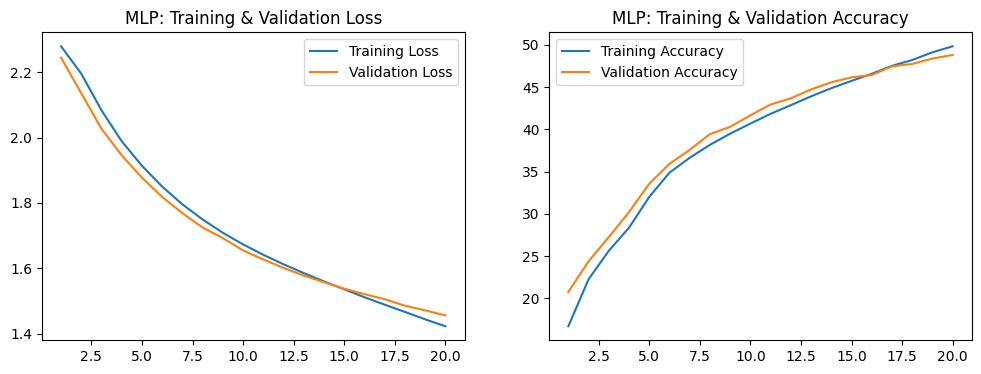

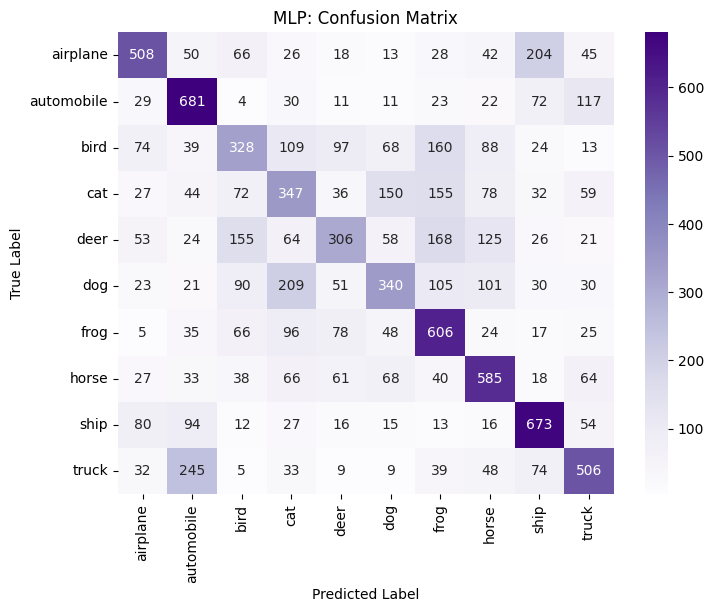

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 512]       1,573,376
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 32]           2,080
             ReLU-11                   [-1, 32]               0
           Linear-12                   [-1, 10]             330
Total params: 1,748,266
Trainable params: 1,748,266
Non-trainable params: 0
---------------------------

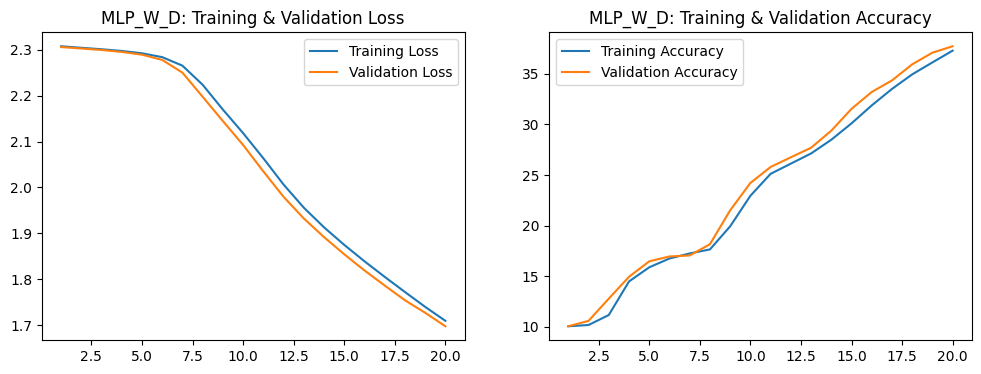

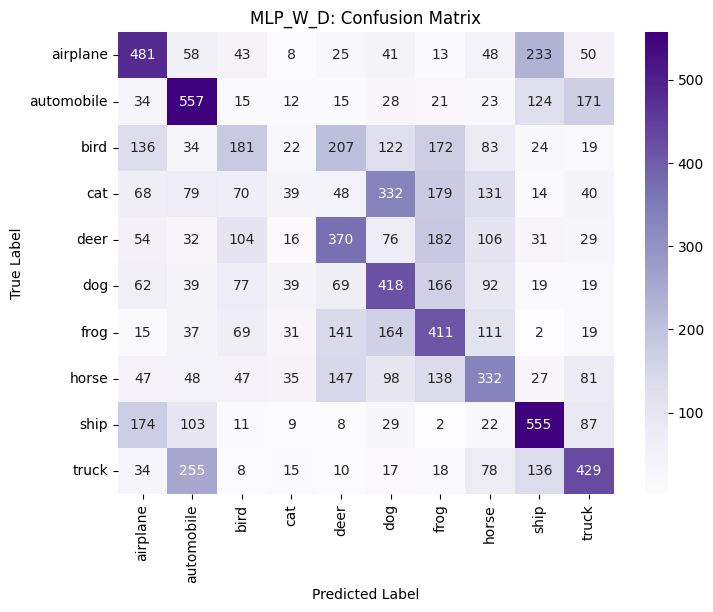

In [ ]:
for name, (train_loss, train_acc, val_loss, val_acc, true_labels, pred_labels) in results.items():

    summary(model, (3, 32, 32))
    print(f'Final Training Loss: {train_loss[-1]}')
    print(f'Final Validation Loss: {val_loss[-1]}')
    print(f'Final Training Accuracy : {train_acc[-1]} %')
    print(f'Final Validation Accuracy : {val_acc[-1]} %')

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.title(f'{name}: Training & Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_acc, label='Training Accuracy')
    plt.plot(range(1, epochs+1), val_acc, label='Validation Accuracy')
    plt.title(f'{name}: Training & Validation Accuracy')
    plt.legend()

    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{name}: Confusion Matrix')
    plt.show()

Compare the models to each other and to a naive baseline

In [ ]:
def check_need_more_epochs(train_loss, val_loss, train_acc, val_acc):
    """
    Heuristic check to see if model might benefit from more epochs:
      - If validation accuracy is still significantly increasing
        near the final epochs.
    """
    if len(val_acc) >= 2:
        improvement = val_acc[-1] - val_acc[-2]
        if improvement > 0.5:  # threshold for "significant" improvement
            return True
    return False


def check_overfitting(train_loss, val_loss, train_acc, val_acc):
    """
    Heuristic check for signs of overfitting:
      - If training accuracy is much higher than validation accuracy.
      - If training loss is going down while validation loss is going up significantly.
    """
    acc_diff = train_acc[-1] - val_acc[-1]  # difference in final accuracy
    if len(train_loss) >= 2 and len(val_loss) >= 2:
        train_loss_trend = train_loss[-1] - train_loss[-2]
        val_loss_trend = val_loss[-1] - val_loss[-2]
        # Overfitting if big gap in accuracy AND training loss is dropping
        # while validation loss is increasing
        if acc_diff > 10.0 and (train_loss_trend < 0 < val_loss_trend):
            return True
    return False


def compare_models(results_dict, baseline_acc=10.0):
    """
    Compare the final results of the MLP and MLP_W_D models.
    Also compare to a naive baseline accuracy, e.g. 10% for CIFAR-10 random guess.
    """
    final_scores = {}
    for name, (train_loss, train_acc, val_loss, val_acc, true_labels, pred_labels) in results_dict.items():
        final_scores[name] = {
            'train_loss': train_loss[-1],
            'val_loss': val_loss[-1],
            'train_acc': train_acc[-1],
            'val_acc': val_acc[-1]
        }

    # Print comparison
    for model_name, stats in final_scores.items():
        print(f"\nModel: {model_name}")
        print(f"  - Final Training Accuracy:  {stats['train_acc']:.2f}%")
        print(f"  - Final Validation Accuracy:{stats['val_acc']:.2f}%")
        print(f"  - Final Training Loss:      {stats['train_loss']:.4f}")
        print(f"  - Final Validation Loss:    {stats['val_loss']:.4f}")

        # Compare to baseline
        if stats['val_acc'] > baseline_acc:
            print(f"  --> Outperforms naive baseline of {baseline_acc}% accuracy.")
        else:
            print(f"  --> Below or near naive baseline ({baseline_acc}%).")

    # If both MLP and MLP_W_D exist, compare them
    if "MLP" in final_scores and "MLP_W_D" in final_scores:
        diff = final_scores["MLP_W_D"]['val_acc'] - final_scores["MLP"]['val_acc']
        print("\nDifference in Validation Accuracy (MLP_W_D - MLP): "
              f"{diff:.2f}%")
        if diff > 0:
            print("MLP_W_D performs better on the validation set.")
        elif diff < 0:
            print("MLP performs better on the validation set.")
        else:
            print("Both models perform equally on the validation set.")
    print()


# Go through each model in results and print analysis
for model_name, (train_loss, train_acc, val_loss, val_acc, true_labels, pred_labels) in results.items():
    print(f"--- Automated Analysis for {model_name} ---")

    # 1) Check if the model might need more epochs
    if check_need_more_epochs(train_loss, val_loss, train_acc, val_acc):
        print("  - This model may still be improving; consider training longer.")
    else:
        print("  - Model appears to have mostly converged at current epochs.")

    # 2) Check for overfitting
    if check_overfitting(train_loss, val_loss, train_acc, val_acc):
        print("  - Potential signs of overfitting detected.")
    else:
        print("  - No strong signs of overfitting based on the heuristics.")

compare_models(results, baseline_acc=10.0)


--- Automated Analysis for MLP ---
  - Model appears to have mostly converged at current epochs.
  - No strong signs of overfitting based on the heuristics.
--- Automated Analysis for MLP_W_D ---
  - This model may still be improving; consider training longer.
  - No strong signs of overfitting based on the heuristics.

Model: MLP
  - Final Training Accuracy:  49.82%
  - Final Validation Accuracy:48.80%
  - Final Training Loss:      1.4221
  - Final Validation Loss:    1.4553
  --> Outperforms naive baseline of 10.0% accuracy.

Model: MLP_W_D
  - Final Training Accuracy:  37.30%
  - Final Validation Accuracy:37.73%
  - Final Training Loss:      1.7093
  - Final Validation Loss:    1.6973
  --> Outperforms naive baseline of 10.0% accuracy.

Difference in Validation Accuracy (MLP_W_D - MLP): -11.07%
MLP performs better on the validation set.

